In [3]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [4]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
100% 788M/788M [00:41<00:00, 23.9MB/s]
100% 788M/788M [00:41<00:00, 19.9MB/s]


In [5]:
local_zip = '/content/microsoft-catsvsdogs-dataset.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [7]:
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):

    training_dir = 'training'
    training_dir_path = os.path.join(root_path, training_dir)
    os.makedirs(training_dir_path)
    validation_dir = 'validation'
    validation_dir_path = os.path.join(root_path, validation_dir)
    os.makedirs(validation_dir_path)
    cats = 'cats'
    train_path = os.path.join(training_dir_path,cats)
    valdiation_path = os.path.join(validation_dir_path,cats)
    os.makedirs(train_path)
    os.makedirs(valdiation_path)
    dogs = 'dogs'
    train_path = os.path.join(training_dir_path,dogs)
    valdiation_path = os.path.join(validation_dir_path,dogs)
    os.makedirs(train_path)
    os.makedirs(valdiation_path)


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


In [9]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  list = os.listdir(SOURCE_DIR)
  list = random.sample(list, len(list))
  index = 0
  zero_length_files = 0
  for img in list:
    path = os.path.join(SOURCE_DIR, img)
    if os.path.getsize(path) == 0:
      zero_length_files = zero_length_files + 1
      print(f'{img} is zero length, so ignoring.')
    else:
      if index < len(list) * SPLIT_SIZE - zero_length_files:
        shutil.copyfile(path, os.path.join(TRAINING_DIR, img))
        index=index+1
      else:
        shutil.copyfile(path, os.path.join(VALIDATION_DIR, img))
        index=index+1


In [10]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")


if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

split_size = .9


split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)


print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")


print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [27]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=256,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  validation_datagen = ImageDataGenerator(rescale=1/255)


  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=256,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

In [17]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input((150,150,3)),
      tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')
  ])


  model.compile(optimizer=Adam(learning_rate=3e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])


  return model

In [26]:
model = create_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,374,849 (12.87 MB)

 Trainable params: 3,374,849 (12.87 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
59/88 ━━━━━━━━━━━━━━━━━━━━ 16s 572ms/step - accuracy: 0.5250 - loss: 0.6908

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 633ms/step - accuracy: 0.5428 - loss: 0.6830 - val_accuracy: 0.6743 - val_loss: 0.5795
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 416ms/step - accuracy: 0.7103 - loss: 0.5602 - val_accuracy: 0.7459 - val_loss: 0.5198
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.7547 - loss: 0.5041 - val_accuracy: 0.7431 - val_loss: 0.5136
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.7867 - loss: 0.4575 - val_accuracy: 0.7919 - val_loss: 0.4330
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.8115 - loss: 0.4120 - val_accuracy: 0.8071 - val_loss: 0.4289
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step - accuracy: 0.8359 - loss: 0.3746 - val_accuracy: 0.8315 - val_loss: 0.3743
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.8544 - loss: 0.3392 - val_accuracy: 0.8415 - val_loss: 0.3537
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.8707 - loss: 0.3084 - val_accuracy: 0.831

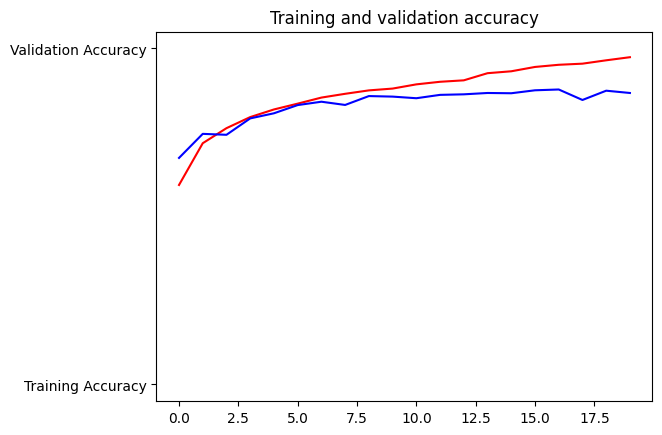

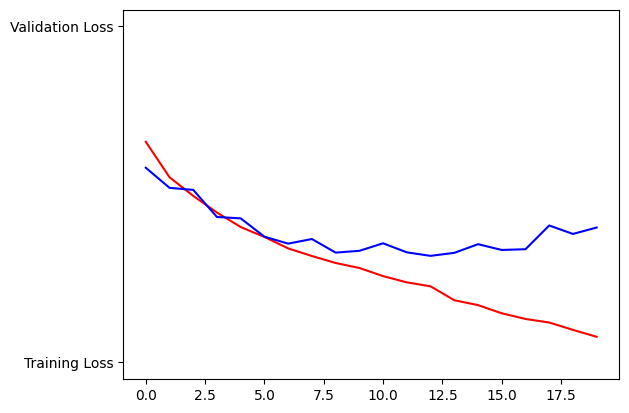

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [23]:
from google.colab import files
model.save('model_v1.keras')
files.download('model_v1.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>